# 2. Projekat iz predmeta **Mašinsko učenje**
**Dataset:**  
[E-commerce Cosmetic Products](https://www.kaggle.com/datasets/devi5723/e-commerce-cosmetics-dataset)

U ovom projektu bavimo se problemom klasterizacije podataka, sa ciljem identifikacije sličnih proizvoda u e-commerce okruženju. 
Skup podataka sadrži informacije o kozmetičkim proizvodima koji se prodaju putem online platformi, uključujući njihove cenovne karakteristike, popularnost i osnovne opisne atribute.

## Osobine (feature-i)
Za potrebe klasterizacije korišćen je podskup atributa koji su relevantni za segmentaciju proizvoda u e-commerce sistemu:
- Price - cena proizvoda
- Rating - prosečna ocena proizvoda
- Number of Ratings - broj korisničkih ocena 
- Category - glavna kategorija proizvoda
- Form - oblik proizvoda 

Numeričke osobine korišćene su za analizu cenovnog ranga i popularnosti proizvoda, dok su kategorijske osobine omogućile grupisanje proizvoda prema njihovim osnovnim karakteristikama.

Cilj ovog projekta je primena i upoređivanje različitih algoritama za klasterizaciju u cilju:
identifikacije različitih tržišnih segmenata proizvoda (npr. niskobudžetni, srednji i premium proizvodi),
analize sličnosti između proizvoda na osnovu cene, popularnosti i osnovnih karakteristika,
ispitivanja uticaja preprocesiranja podataka, redukcije dimenzionalnosti i obrade outlier-a na kvalitet dobijenih klastera.

### 1. Setup i učitavanje
#### 1.1. Import biblioteka i setovanje konstantni

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Paleta boja: roze, plava, ljubičasta
COLORS = {
    'pink': '#E91E63',
    'pink_light': '#F48FB1',
    'purple': '#9C27B0',
    'purple_light': '#CE93D8',
    'blue': '#5C6BC0',
    'blue_light': '#9FA8DA',
}

COLOR_PALETTE = ['#E91E63', '#9C27B0', '#5C6BC0', '#F48FB1', '#CE93D8', '#9FA8DA']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

#### 1.2. Učitavanje podataka i pregled strukture

In [298]:
dataset = pd.read_csv('data/E-commerce-cosmetic-dataset.csv', encoding='latin-1')

dataset.info()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12615 entries, 0 to 12614
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12615 non-null  object 
 1   website       12615 non-null  object 
 2   country       12615 non-null  object 
 3   category      12615 non-null  object 
 4   subcategory   12615 non-null  object 
 5   title-href    12615 non-null  object 
 6   price         12298 non-null  float64
 7   brand         12615 non-null  object 
 8   ingredients   6600 non-null   object 
 9   form          12615 non-null  object 
 10  type          9934 non-null   object 
 11  color         10626 non-null  object 
 12  size          9449 non-null   object 
 13  rating        10548 non-null  object 
 14  noofratings   12156 non-null  object 
dtypes: float64(1), object(14)
memory usage: 1.4+ MB


,price
count,12298.000000
mean,2281.180935
std,3158.690307
min,1.700000
25%,499.000000
50%,1307.200000
75%,2859.500000
max,94099.000000


In [299]:
dataset.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,60,4.2,61
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,100,4.3,342


#### 1.3. Konverzija valute (INR → EUR)

Dataset sadrži cene u indijskim rupijama (INR). Konvertujemo u evre (EUR) za lakšu interpretaciju.

In [300]:
INR_TO_EUR = 0.0094

dataset['price'] = dataset['price'] * INR_TO_EUR

print(f"\nStatistika cena u EUR:")
dataset.describe()


Statistika cena u EUR:


,price
count,12298.000000
mean,21.443101
std,29.691689
min,0.015980
25%,4.690600
50%,12.287680
75%,26.879300
max,884.530600


#### 1.4. Čišćenje kritičnih kolona (rating, noofratings, size)

Pre EDA, čistimo kolone koje su ključne za klasterizaciju.

In [301]:
import re

# ============================================================
# ČIŠĆENJE KOLONE: noofratings
# ============================================================
def clean_noofratings(value):
    """
    Čisti vrednosti u koloni noofratings:
    - "No reviews", "Write a review", "New to Amazon" → 0
    - "X ratings" → X (ekstraktuje broj)
    - "4,031" → 4031 (uklanja zareze)
    - NaN → NaN
    """
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip().lower()
    
    # Slučajevi koji označavaju 0 recenzija
    zero_indicators = ['no reviews', 'write a review', 'new to amazon', 'be the first to review', '']
    if value in zero_indicators:
        return 0.0
    
    # Ukloni "ratings" ili "rating" sufiks
    value = value.replace('ratings', '').replace('rating', '').strip()
    
    # Ukloni zareze iz brojeva
    value = value.replace(',', '')
    
    try:
        return float(value)
    except ValueError:
        return np.nan

# ============================================================
# ČIŠĆENJE KOLONE: size (SVE KONVERTOVANO U MILILITRE)
# ============================================================
def clean_size_to_ml(value):
    """
    Čisti vrednosti u koloni size i konvertuje SVE u mililitre (ml).
    
    Konverzije:
    - Kilos → g (×1000) → ml (gustina ~1 za kozmetiku)
    - Pounds → g (×453.592) → ml
    - Ounces → g (×28.3495) → ml
    - Fluid ounces → ml (×29.5735)
    - Cubic centimetres → ml (×1, jer 1cc = 1ml)
    - Millis → ml (već mililitra)
    - Centi → ml (×10, pretpostavka: centilitri)
    - "X s" → ml (greška parsiranja, "s" = "g")
    - Čisti brojevi → ml (pretpostavka)
    - "count", vrednosti sa zarezima → NaN
    """
    if pd.isna(value):
        return np.nan
    
    value_orig = str(value).strip()
    value = value_orig.lower()
    
    # Nevalidne vrednosti → NaN
    if 'count' in value:
        return np.nan
    if ' , ' in value:  # "1 , 250 " format
        return np.nan
    
    # Ekstraktuj broj
    match = re.search(r'([\d.]+)', value)
    if not match:
        return np.nan
    
    try:
        num = float(match.group(1))
    except ValueError:
        return np.nan
    
    # Konverzije u ml
    # Za masu → ml, koristimo gustinu ~1 g/ml (tipično za kozmetiku)
    
    if 'kilo' in value:
        # kg → g → ml
        return num * 1000
    
    elif 'pound' in value:
        # lb → g → ml
        return num * 453.592
    
    elif 'fluid ounce' in value or 'fl oz' in value:
        # fl oz → ml (direktna konverzija zapremine)
        return num * 29.5735
    
    elif 'ounce' in value:
        # oz (težina) → g → ml
        return num * 28.3495
    
    elif 'cubic centimetre' in value or 'cubic centimeter' in value:
        # cc → ml (1:1)
        return num
    
    elif 'millis' in value or 'milli' in value:
        # već ml
        return num
    
    elif 'centi' in value:
        # pretpostavka: centilitri → ml
        return num * 10
    
    elif re.match(r'^[\d.]+\s*s$', value):
        # "5 s" format - greška parsiranja, "s" = "g" (grami)
        # g → ml (gustina ~1)
        return num
    
    else:
        # Čisti brojevi - pretpostavljamo da su već u ml
        return num

# ============================================================
# PRIMENA ČIŠĆENJA
# ============================================================
print("Pre čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")
print(f"  size:        {dataset['size'].notna().sum()} non-null, tip: {dataset['size'].dtype}")

# 1. Čišćenje noofratings
dataset['noofratings'] = dataset['noofratings'].apply(clean_noofratings)

# 2. Čišćenje size - SVE U MILILITRE
dataset['size'] = dataset['size'].apply(clean_size_to_ml)

# 3. Konverzija rating u float
dataset['rating'] = pd.to_numeric(dataset['rating'], errors='coerce')

# 4. Kreiranje flag-a has_reviews
dataset['has_reviews'] = (dataset['noofratings'] > 0).astype(int)

# 5. Logika: ako noofratings == 0, rating nije validan
dataset.loc[dataset['noofratings'] == 0, 'rating'] = np.nan

print("\nPosle čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")
print(f"  size:        {dataset['size'].notna().sum()} non-null, tip: {dataset['size'].dtype}")
print(f"  has_reviews: nova kolona kreirana")

print("\n" + "="*60)
print("STATISTIKE POSLE ČIŠĆENJA:")
print("="*60)
print(dataset[['price', 'rating', 'noofratings', 'size']].describe())

print("\n" + "="*60)
print("SIZE KOLONA - SADA U MILILITRIMA (ml):")
print("="*60)
print(f"Min: {dataset['size'].min():.2f} ml")
print(f"Max: {dataset['size'].max():.2f} ml")
print(f"Median: {dataset['size'].median():.2f} ml")
print(f"Mean: {dataset['size'].mean():.2f} ml")

Pre čišćenja:
  rating:      10548 non-null, tip: object
  noofratings: 12156 non-null, tip: object
  size:        9449 non-null, tip: object

Posle čišćenja:
  rating:      10516 non-null, tip: float64
  noofratings: 12156 non-null, tip: float64
  size:        9446 non-null, tip: float64
  has_reviews: nova kolona kreirana

STATISTIKE POSLE ČIŠĆENJA:
              price        rating    noofratings         size
count  12298.000000  10516.000000   12156.000000  9446.000000
mean      21.443101      4.865643    1032.217259   113.961474
std       29.691689     18.539207    6690.827242   217.774445
min        0.015980      1.000000       0.000000     0.000000
25%        4.690600      4.000000       8.000000     8.100000
50%       12.287680      4.200000      31.000000    48.000000
75%       26.879300      4.500000     289.000000   135.000000
max      884.530600    925.000000  220040.000000  7500.000000

SIZE KOLONA - SADA U MILILITRIMA (ml):
Min: 0.00 ml
Max: 7500.00 ml
Median: 48.00 ml
Me

In [302]:
# Uklanjanje duplikata
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')
dataset = dataset.drop_duplicates()
print(f'Broj redova posle uklanjanja: {len(dataset)}')

Broj duplikata: 60
Broj redova posle uklanjanja: 12555


In [303]:
# Finalna provera strukture podataka pre EDA
print("FINALNA STRUKTURA PODATAKA:")
print("="*50)
dataset.info()
print("\n")
dataset.head()

FINALNA STRUKTURA PODATAKA:
<class 'pandas.core.frame.DataFrame'>
Index: 12555 entries, 0 to 12614
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12555 non-null  object 
 1   website       12555 non-null  object 
 2   country       12555 non-null  object 
 3   category      12555 non-null  object 
 4   subcategory   12555 non-null  object 
 5   title-href    12555 non-null  object 
 6   price         12238 non-null  float64
 7   brand         12555 non-null  object 
 8   ingredients   6547 non-null   object 
 9   form          12555 non-null  object 
 10  type          9876 non-null   object 
 11  color         10572 non-null  object 
 12  size          9406 non-null   float64
 13  rating        10466 non-null  float64
 14  noofratings   12102 non-null  float64
 15  has_reviews   12555 non-null  int64  
dtypes: float64(4), int64(1), object(11)
memory usage: 1.6+ MB




,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings,has_reviews
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,5.6306,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19.0,1
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,1.4006,Charlene,NaN,aerosol,NaN,Unit count type:,30.0,4.4,4031.0,1
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,2.8012,Charlene,NaN,aerosol,NaN,Unit count type:,30.0,4.4,4072.0,1
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,2.3030,Denver,NaN,aerosol,NaN,Long-Lasting Scent,60.0,4.2,61.0,1
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,3.9668,Denver,NaN,aerosol,NaN,Long-Lasting Scent,100.0,4.3,342.0,1


### 2. Eksploratorna analiza podataka (EDA)

Pre bilo kakve obrade podataka, neophodno je razumeti njihovu strukturu, distribucije i kvalitet. 
EDA nam pomaže da donesemo informisane odluke o preprocessingu.

#### 2.1. Analiza nedostajućih vrednosti

Nedostajuće vrednosti po kolonama:

             Nedostaje  Procenat (%)
ingredients       6008         47.85
size              3149         25.08
type              2679         21.34
rating            2089         16.64
color             1983         15.79
noofratings        453          3.61
price              317          2.52


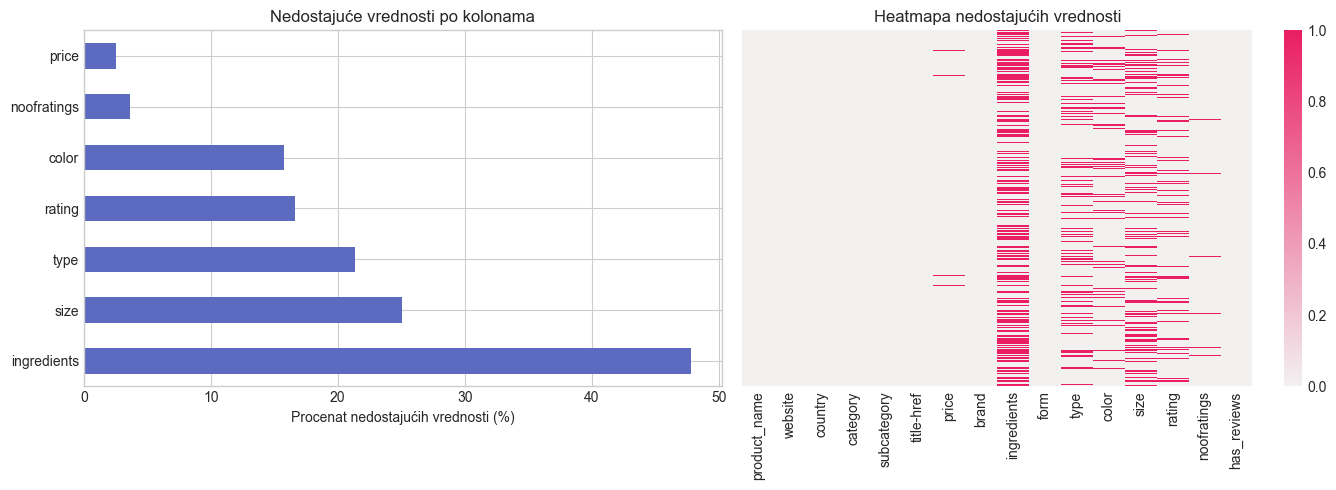

In [304]:
# Pregled nedostajućih vrednosti
missing_data = pd.DataFrame({
    'Nedostaje': dataset.isnull().sum(),
    'Procenat (%)': (dataset.isnull().sum() / len(dataset) * 100).round(2)
}).sort_values(by='Nedostaje', ascending=False)

print("Nedostajuće vrednosti po kolonama:\n")
print(missing_data[missing_data['Nedostaje'] > 0])

# Vizualizacija nedostajućih vrednosti
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
missing_data[missing_data['Nedostaje'] > 0]['Procenat (%)'].plot(
    kind='barh', 
    ax=axes[0],
    color=COLORS['blue']
)
axes[0].set_xlabel('Procenat nedostajućih vrednosti (%)')
axes[0].set_title('Nedostajuće vrednosti po kolonama')

# Heatmap prikaz missing values (uzorak od 500 redova za preglednost)
sample_idx = np.random.choice(len(dataset), size=len(dataset), replace=False)
cmap_custom = sns.light_palette(COLORS['pink'], as_cmap=True)
sns.heatmap(
    dataset.iloc[sample_idx].isnull(), 
    cbar=True, 
    yticklabels=False, 
    cmap=cmap_custom,
    ax=axes[1]
)
axes[1].set_title('Heatmapa nedostajućih vrednosti')

plt.tight_layout()
plt.show()

#### 2.2. Distribucija numeričkih varijabli

Analiziramo distribucije kolona koje su ključne za klasterizaciju: `price`, `rating`, `noofratings` i `size`.

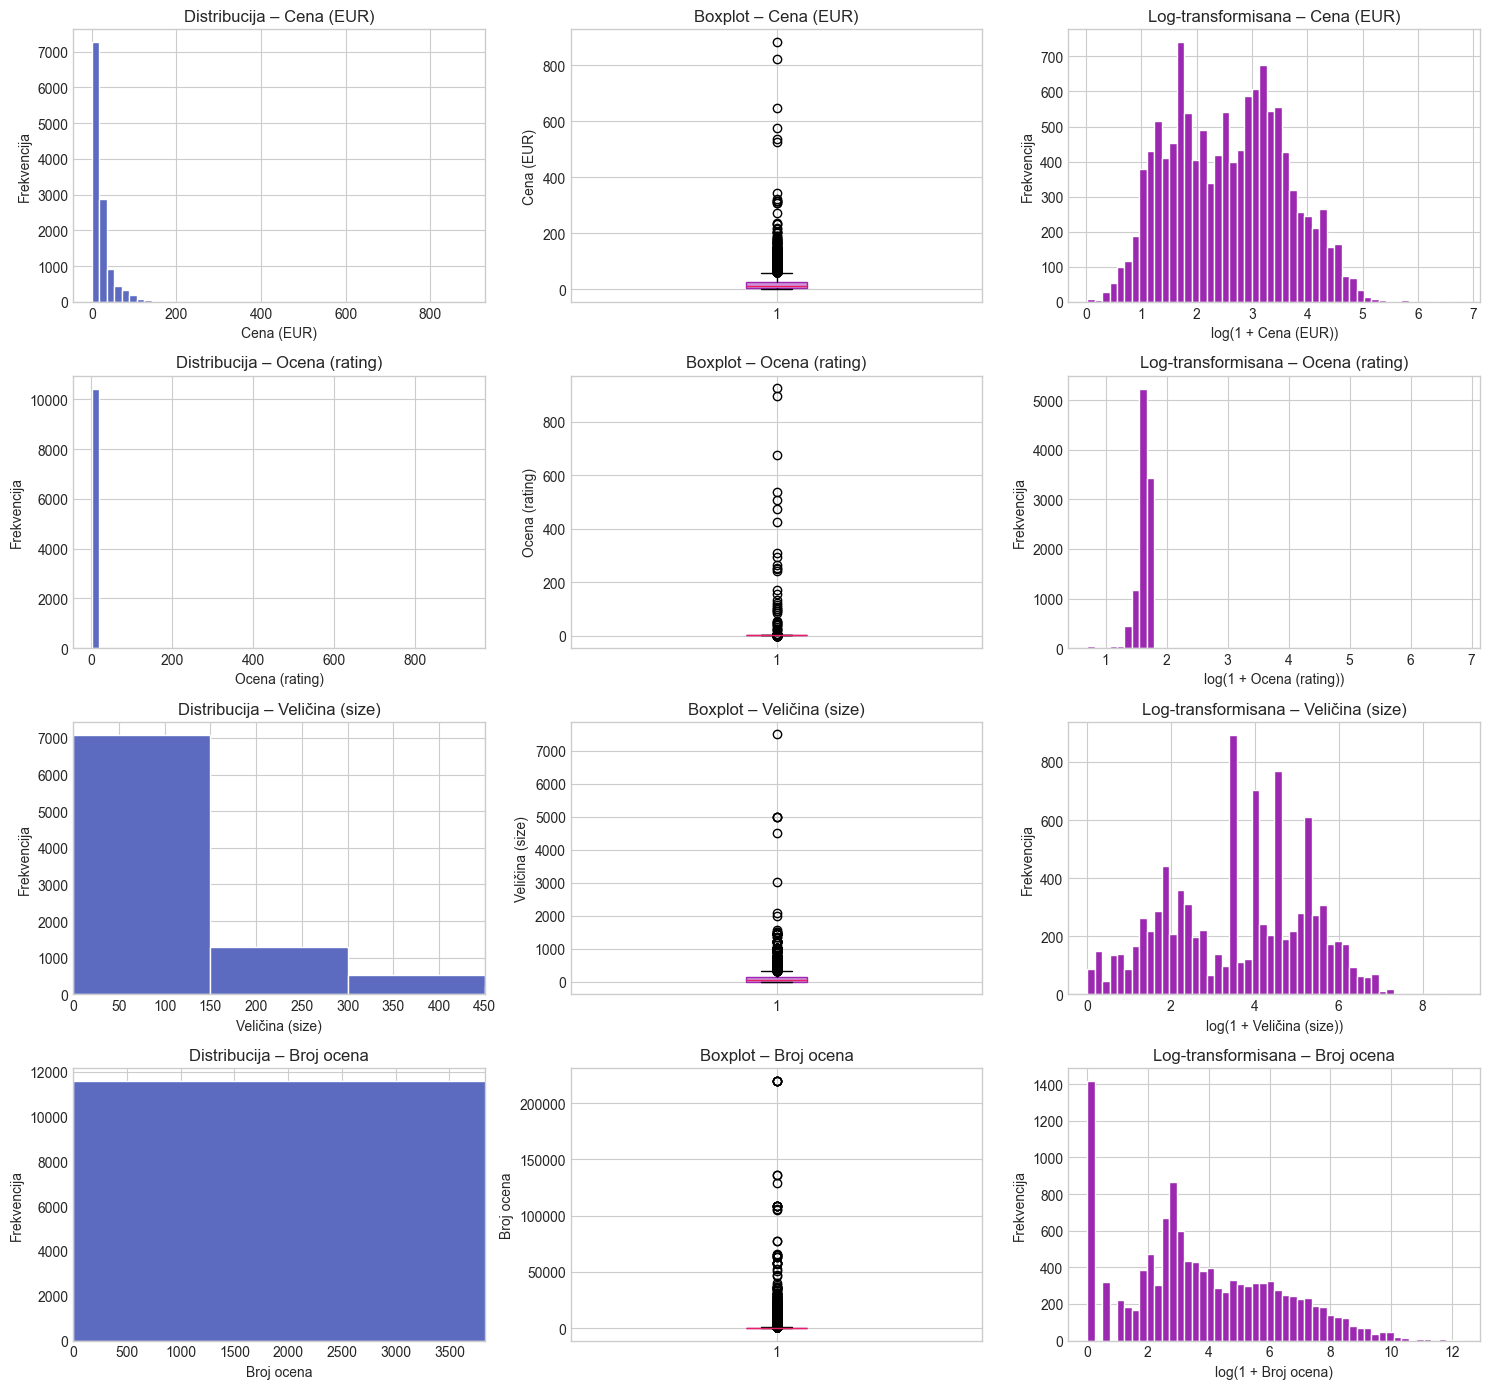


Statistički pregled numeričkih kolona:
              price        rating         size    noofratings
count  12238.000000  10466.000000  9406.000000   12102.000000
mean      21.485583      4.869206   114.284922    1036.605354
std       29.751437     18.583350   218.157979    6705.413616
min        0.015980      1.000000     0.000000       0.000000
25%        4.690600      4.000000     8.100000       8.000000
50%       12.287680      4.200000    48.000000      31.000000
75%       26.879300      4.500000   135.000000     289.750000
max      884.530600    925.000000  7500.000000  220040.000000


In [305]:
# Distribucije numeričkih varijabli: cena, rating, size, broj ocena
fig, axes = plt.subplots(4, 3, figsize=(15, 14))

vars_config = [
    (dataset['price'].dropna(), 'Cena (EUR)'),
    (dataset['rating'].dropna(), 'Ocena (rating)'),
    (dataset['size'].dropna(), 'Veličina (size)'),
    (dataset['noofratings'].dropna(), 'Broj ocena'),
]

for row, (data, label) in enumerate(vars_config):
    # Histogram
    axes[row, 0].hist(data, bins=50, color=COLORS['blue'], edgecolor='white')
    axes[row, 0].set_xlabel(label)
    axes[row, 0].set_ylabel('Frekvencija')
    axes[row, 0].set_title(f'Distribucija – {label}')

    # Boxplot
    bp = axes[row, 1].boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor(COLORS['purple_light'])
    bp['boxes'][0].set_edgecolor(COLORS['purple'])
    bp['medians'][0].set_color(COLORS['pink'])
    axes[row, 1].set_ylabel(label)
    axes[row, 1].set_title(f'Boxplot – {label}')

    # Log-transformisana distribucija
    axes[row, 2].hist(np.log1p(data), bins=50, color=COLORS['purple'], edgecolor='white')
    axes[row, 2].set_xlabel(f'log(1 + {label})')
    axes[row, 2].set_ylabel('Frekvencija')
    axes[row, 2].set_title(f'Log-transformisana – {label}')

    # Ograničenje x-ose za bolju vizualizaciju
    if row >= 2:  # size i noofratings: do 95. percentila
        x_max = data.quantile(0.95)
        axes[row, 0].set_xlim(0, x_max)

plt.tight_layout()
plt.show()

# Statistički pregled
print("\nStatistički pregled numeričkih kolona:")
print(dataset[['price', 'rating', 'size', 'noofratings']].describe())

#### 2.3. Analiza kategorijskih kolona

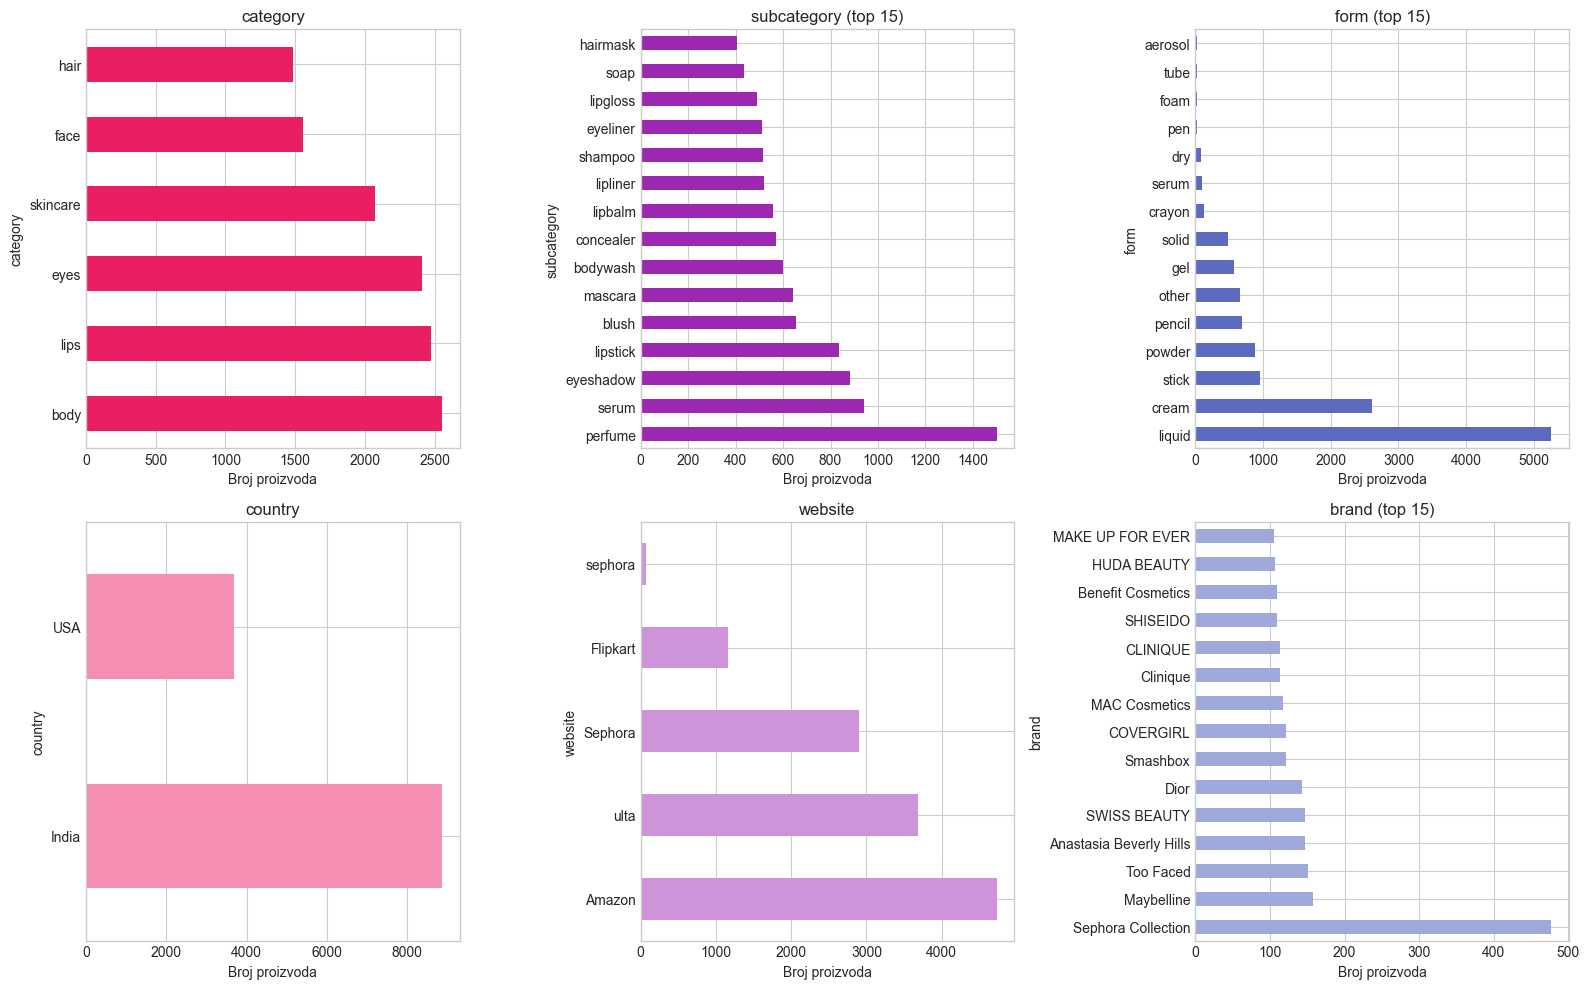

In [306]:
# Kategoričke kolone za analizu
categorical_cols = ['category', 'subcategory', 'form', 'country', 'website', 'brand']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = dataset[col].value_counts()
    
    # Za kolone sa mnogo kategorija, prikaži top 15
    if len(value_counts) > 15:
        value_counts = value_counts.head(15)
        title = f'{col} (top 15)'
    else:
        title = col
    

    color = COLOR_PALETTE[idx % len(COLOR_PALETTE)]
    value_counts.plot(kind='barh', ax=axes[idx], color=color)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Broj proizvoda')

plt.tight_layout()
plt.show()

In [307]:
# Sumarni pregled kategoričkih kolona
print("Broj jedinstvenih vrednosti po kategoričkoj koloni:\n")
for col in categorical_cols:
    unique_count = dataset[col].nunique()
    print(f"{col}: {unique_count} jedinstvenih vrednosti")

Broj jedinstvenih vrednosti po kategoričkoj koloni:

category: 6 jedinstvenih vrednosti
subcategory: 36 jedinstvenih vrednosti
form: 25 jedinstvenih vrednosti
country: 2 jedinstvenih vrednosti
website: 5 jedinstvenih vrednosti
brand: 1753 jedinstvenih vrednosti


#### 2.4. Zaključci EDA

Na osnovu sprovedene eksploratorne analize, identifikovani su sledeći ključni uvidi:

**Nedostajuće vrednosti:**
- `ingredients` ima najviše nedostajućih vrednosti (~48%) - nije pogodna za klasterizaciju
- `size`, `type`, `rating`, `color` imaju značajan procenat nedostajućih vrednosti
- `price` ima mali procenat (~2.5%) nedostajućih vrednosti

**Distribucije:**
- `price` ima izrazito desno zakošenu (right-skewed) distribuciju sa outlierima
- Log-transformacija cene daje približno normalnu distribuciju
- `rating`, `noofratings` i `size` zahtevaju konverziju iz string formata

**Kategoričke varijable:**
- `brand` ima previše jedinstvenih vrednosti - nije pogodna za one-hot encoding
- `category`, `subcategory`, `form` imaju manji broj kategorija - pogodne za analizu
- Dataset pokriva uglavnom indijsko tržište (Flipkart)

**Preporuke za preprocessing:**
1. Konvertovati `rating`, `noofratings`, `size` u numerički format
2. Razmotriti log-transformaciju za `price`
3. Dropovati kolone sa previše nedostajućih vrednosti (`ingredients`, `type`, `color`)
4. Zadržati `size` za računanje `price_per_unit`